In [5]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
from sqlalchemy import *
from sqlalchemy.engine import create_engine
from sqlalchemy.schema import *
from urllib import quote_plus as urlquote

password = "Casstime@com1112"
engine2 = create_engine('mysql+pymysql://reader:%s@172.21.21.78:3306/kscredit'%urlquote(password))

def get_sql(sql,engine):
    df = pd.read_sql(sql=sql,con = engine)
    return df

# 授信额度  
sql = """
SELECT cai.`cf_apply_no`,cai.`cust_name` AS "维修厂名称",
       cxemr.`ett_mem_code` AS "开思编码",
       cxemr.xm_mem_code AS "徙木编码",
       CASE lbi.`fclt_code` WHEN 'PRODA05XIMU239557065838694400C' THEN "白条" WHEN 'PRODA05XIMU239619100458881024C' THEN "挂账" ELSE "" END AS "授信方式",
cai.cr_date AS "授信日期",
cai.`gds_acard_score` AS "初始A卡分",
crrx2.cf_apply_id,
CASE WHEN cai.`gds_acard_score` IS NULL THEN '线下初始化'
     WHEN cai.`gds_acard_score` IS NOT NULL AND crrx1.cf_apply_id IS NULL THEN '自动审批' 
     WHEN cai.`gds_acard_score` IS NOT NULL AND crrx1.cf_apply_id IS NOT NULL THEN '人工审批' END AS "审批方式",
CASE WHEN crrx1.`cf_apply_id` IS NULL THEN crrx2.cf_amount ELSE crrx1.cf_amount/1000000 END AS "模型给予额度",
CASE WHEN crrx1.`cf_apply_id` IS NULL THEN crrx2.`gds_desc` ELSE crrx1.`gds_desc` END AS "模型给予额度描述",
crrx2.cf_amount/1000000 AS "最后授信额度",
crrx2.gds_desc AS "最后授信额度描述",
lbi.cust_la/1000000 AS "当前固定额度"
FROM `cf_apply_info` cai 
INNER JOIN `cust_xm_ett_mem_rel` cxemr ON cai.`mem_code`= cxemr.`xm_mem_code`
INNER JOIN `la_base_info` lbi ON lbi.`cf_apply_id`= cai.`id` AND lbi.`fclt_code` = cai.`fclt_code` 
LEFT JOIN (
SELECT cf1.*
FROM `cf_gds_result_record_ximu` cf1
JOIN (SELECT cf_apply_id,gds_result,MAX(cr_date) AS cr_date FROM cf_gds_result_record_ximu GROUP BY cf_apply_id,gds_result) cf2
ON cf1.cf_apply_id = cf2.cf_apply_id AND cf1.gds_result = cf2.gds_result AND cf1.cr_date = cf2.cr_date
WHERE cf1.gds_desc <> 'test' AND cf1.gds_result <> 'NO_ADMITTANCE'
AND cf1.gds_result = 'WAITMANUALAPPROVE'
) crrx1 ON crrx1.`cf_apply_id` = cai.`id` 
LEFT JOIN (
SELECT cf1.*
FROM `cf_gds_result_record_ximu` cf1
JOIN (SELECT cf_apply_id,gds_result,MAX(cr_date) AS cr_date FROM cf_gds_result_record_ximu GROUP BY cf_apply_id,gds_result) cf2
ON cf1.cf_apply_id = cf2.cf_apply_id AND cf1.gds_result = cf2.gds_result AND cf1.cr_date = cf2.cr_date
WHERE cf1.gds_desc <> 'test' AND cf1.gds_result <> 'NO_ADMITTANCE'
AND cf1.gds_result = 'ADMITTANCE'
) crrx2 ON crrx2.`cf_apply_id` = cai.`id`
WHERE cai.`delete_flag` = 0
ORDER BY cai.`cust_code` , cai.`fclt_code` 
"""

df1 = get_sql(sql,engine2)
#df['ett_id'] = df['ett_id'].astype(str)
# df.to_excel(u'D:/casstime_ana/12_客户额度调整记录/完整额度审批情况_0426.xlsx')


In [6]:
# 授信后最近一次调固额记录
sql2 = '''
SELECT a.la_id,a.lat/100 AS lat,a.cr_date,a.cr_user_id,b.nick_name,b.role_name,t1.cust_id,cf.mem_code
FROM (SELECT lac.* FROM la_amount_change_log lac
JOIN (SELECT la_id,change_type,MAX(cr_date) AS cr_date FROM la_amount_change_log GROUP BY la_id,change_type)lam
ON lac.la_id = lam.la_id AND lac.change_type = lam.change_type AND lac.cr_date = lam.cr_date
)a 
LEFT JOIN cif_user b ON a.cr_user_id = b.id
LEFT JOIN (SELECT DISTINCT id, cust_id,fclt_code FROM la_base_info)t1 ON a.la_id = t1.id
LEFT JOIN (SELECT DISTINCT cust_id,mem_code FROM cf_apply_info) cf ON t1.cust_id = cf.cust_id
WHERE a.change_type = 'ADJUST_LAT'
'''
df2 = get_sql(sql2,engine2)

In [8]:
df1.head().T

0  \
cf_apply_no                               CRXIMU20191105000001   
维修厂名称                                            深圳市凌空天鸽科技有限公司   
开思编码                                                  C0124315   
徙木编码                                XMMEMBER242886933552828416   
授信方式                                                        白条   
授信日期                                       2019-11-05 02:14:03   
初始A卡分                                                        0   
cf_apply_id                                                NaN   
审批方式                                                      人工审批   
模型给予额度                                                       0   
模型给予额度描述     JMIB0001A0004:A卡评分数据异常-开思商城使用情况;JMIB0001A2012:...   
最后授信额度                                                     NaN   
最后授信额度描述                                                  None   
当前固定额度                                                       2   

                                                             1  \
cf_apply_no                               CRXIMU20191105000002   
维修厂名称                                         深圳市龙岗区平湖信而强食品批发行   
开思编码                                                  C0140846   
徙木编码                                XMMEMBER242892144593866752   
授信方式                                                        挂账   
授信日期                                       2019-11-05 02:15:20   
初始A卡分                                                        0   
cf_apply_id                                                NaN   
审批方式                                                      人工审批   
模型给予额度                                                       0   
模型给予额度描述     JMIB0001A0004:A卡评分数据异常-开思商城使用情况;JMIB0001A2012:...   
最后授信额度                                                     NaN   
最后授信额度描述                                                  None   
当前固定额度                                                       3   

                                                             2  \
cf_apply_no                               CRXIMU20191105000003   
维修厂名称                                            西安德工匠汽车服务有限公司   
开思编码                                                  C0170576   
徙木编码                                XMMEMBER243090453321224192   
授信方式                                                        白条   
授信日期                                       2019-11-05 12:12:08   
初始A卡分                                                        0   
cf_apply_id                                         2.4309e+17   
审批方式                                                      人工审批   
模型给予额度                                                       0   
模型给予额度描述     JMIB0001A0005:A卡评分数据异常-ERP使用情况;DINB0001A2011:首...   
最后授信额度                                                  0.0003   
最后授信额度描述                                                A卡评分出错   
当前固定额度                                                       3   

                                                             3  \
cf_apply_no                               CRXIMU20191105000004   
维修厂名称                                              新罗区鑫添安汽车修理厂   
开思编码                                                  C0108772   
徙木编码                                XMMEMBER243117317880287232   
授信方式                                                        挂账   
授信日期                                       2019-11-05 13:58:55   
初始A卡分                                                        0   
cf_apply_id                                        2.43117e+17   
审批方式                                                      人工审批   
模型给予额度                                                       0   
模型给予额度描述     JMIB0001A0004:A卡评分数据异常-开思商城使用情况;JMIB0001A2012:...   
最后授信额度                                                       3   
最后授信额度描述                                                    同意   
当前固定额度                                                       3   

                                                             4  
cf_apply_no                     

In [9]:
df2.head().T

0                           1  \
la_id               242940742828302336          243117355993931776   
lat                              30000                       30000   
cr_date            2019-12-13 19:33:53         2019-11-05 14:02:50   
cr_user_id                          23                          27   
nick_name                           胡婷                          郑杰   
role_name                          管理员                       开思_风控   
cust_id             242892153695506432          243090465308545024   
mem_code    XMMEMBER242892144593866752  XMMEMBER243090453321224192   

                                     2                           3  \
la_id               243126594447613952          243131605269356544   
lat                              50000                       50000   
cr_date            2019-11-05 14:37:05         2019-11-05 16:33:06   
cr_user_id                          25                          25   
nick_name                           章黎                          章黎   
role_name                        开思_风控                       开思_风控   
cust_id             243125468482506752          243131298107887616   
mem_code    XMMEMBER243125457808003072  XMMEMBER243131284375736320   

                                     4  
la_id               243155747892895744  
lat                              50000  
cr_date            2019-11-05 16:45:21  
cr_user_id                          27  
nick_name                           郑杰  
role_name                        开思_风控  
cust_id             243155335353733120  
mem_code    XMMEMBER243155294450880512

In [11]:
df = df1.merge(df2,left_on = u"徙木编码",right_on = 'mem_code',how = 'left')

In [12]:
df.head().T

0  \
cf_apply_no                               CRXIMU20191105000001   
维修厂名称                                            深圳市凌空天鸽科技有限公司   
开思编码                                                  C0124315   
徙木编码                                XMMEMBER242886933552828416   
授信方式                                                        白条   
授信日期                                       2019-11-05 02:14:03   
初始A卡分                                                        0   
cf_apply_id                                                NaN   
审批方式                                                      人工审批   
模型给予额度                                                       0   
模型给予额度描述     JMIB0001A0004:A卡评分数据异常-开思商城使用情况;JMIB0001A2012:...   
最后授信额度                                                     NaN   
最后授信额度描述                                                  None   
当前固定额度                                                       2   
la_id                                                      NaN   
lat                                                        NaN   
cr_date                                                    NaT   
cr_user_id                                                 NaN   
nick_name                                                  NaN   
role_name                                                  NaN   
cust_id                                                    NaN   
mem_code                                                   NaN   

                                                             1  \
cf_apply_no                               CRXIMU20191105000002   
维修厂名称                                         深圳市龙岗区平湖信而强食品批发行   
开思编码                                                  C0140846   
徙木编码                                XMMEMBER242892144593866752   
授信方式                                                        挂账   
授信日期                                       2019-11-05 02:15:20   
初始A卡分                                                        0   
cf_apply_id                                                NaN   
审批方式                                                      人工审批   
模型给予额度                                                       0   
模型给予额度描述     JMIB0001A0004:A卡评分数据异常-开思商城使用情况;JMIB0001A2012:...   
最后授信额度                                                     NaN   
最后授信额度描述                                                  None   
当前固定额度                                                       3   
la_id                                              2.42941e+17   
lat                                                      30000   
cr_date                                    2019-12-13 19:33:53   
cr_user_id                                                  23   
nick_name                                                   胡婷   
role_name                                                  管理员   
cust_id                                            2.42892e+17   
mem_code                            XMMEMBER242892144593866752   

                                                             2  \
cf_apply_no                               CRXIMU20191105000003   
维修厂名称                                            西安德工匠汽车服务有限公司   
开思编码                                                  C0170576   
徙木编码                                XMMEMBER243090453321224192   
授信方式                                                        白条   
授信日期                                       2019-11-05 12:12:08   
初始A卡分                                                        0   
cf_apply_id                                         2.4309e+17   
审批方式                                                      人工审批   
模型给予额度                                                       0   
模型给予额度描述     JMIB0001A0005:A卡评分数据异常-ERP使用情况;DINB0001A2011:首...   
最后授信额度                                                  0.0003   
最后授信额度描述                                                A卡评分出错   
当前固定额度                                                       3   
la_id                            

In [14]:
df.to_excel(u'D:/casstime_ana/12_客户额度调整记录/la_analysis_backup.xlsx')
# 拉出底表后手工反推档位，是否调降/调升

In [15]:
import pandas as pd 
import numpy as np
df = pd.read_excel(u'D:/casstime_ana/7_yepeng/la_back_yp_0428.xlsx') 
df = df[df['审批方式']=='人工审批']
df.head().T

0  \
cf_apply_no                               CRXIMU20200427000934   
维修厂名称                                             深圳市爱驾车汽车有限公司   
开思编码                                                  C0122822   
徙木编码                                XMMEMBER306229971829923840   
授信方式                                                        挂账   
授信日期                                       2020-04-27 17:46:05   
初始A卡分                                                      650   
cf_apply_id                                         3.0623e+17   
审批方式                                                      人工审批   
模型给予额度                                                      10   
一档                                                           5   
二档                                                          10   
是否1档                                                         0   
是否2档                                                         1   
模型给予额度描述     JMIB0001A2012:首次交易距今时长小于3个月-未获取到数据;JMIB0001A20...   
最后授信额度                                                       4   
调升/调降                                                       调降   
最后授信额度描述                                                    TY   
当前固定额度                                                       4   
la_id                                                      NaN   
lat                                                        NaN   
cr_date                                                    NaT   
cr_user_id                                                 NaN   
nick_name                                                  NaN   
role_name                                                  NaN   
cust_id                                                    NaN   
mem_code                                                   NaN   

                                                             1  \
cf_apply_no                               CRXIMU20200427000933   
维修厂名称                                           成都锐意名车汽车维修有限公司   
开思编码                                                  C0109869   
徙木编码                                XMMEMBER306229727381737472   
授信方式                                                        挂账   
授信日期                                       2020-04-27 17:45:05   
初始A卡分                                                      663   
cf_apply_id                                         3.0623e+17   
审批方式                                                      人工审批   
模型给予额度                                                       6   
一档                                                           6   
二档                                                          12   
是否1档                                                         1   
是否2档                                                         0   
模型给予额度描述     JMIB0001A2012:首次交易距今时长小于3个月-未获取到数据;JMIB0001A20...   
最后授信额度                                                       2   
调升/调降                                                       调降   
最后授信额度描述                                         经营一年，规模一般  通过   
当前固定额度                                                       2   
la_id                                                      NaN   
lat                                                        NaN   
cr_date                                                    NaT   
cr_user_id                                                 NaN   
nick_name                                                  NaN   
role_name                                                  NaN   
cust_id                                                    NaN   
mem_code                                                   NaN   

                                                             2  \
cf_apply_no                               CRXIMU20200427000932   
维修厂名称                                           广州市福来临汽车服务有限公司   
开思编码                                                  C0142640   
徙木编码                                XMMEMBER306229433688150016   
授信方式                             

In [16]:
len(df['初始A卡分'])

2243

Text(0.5,1,'Level 2')

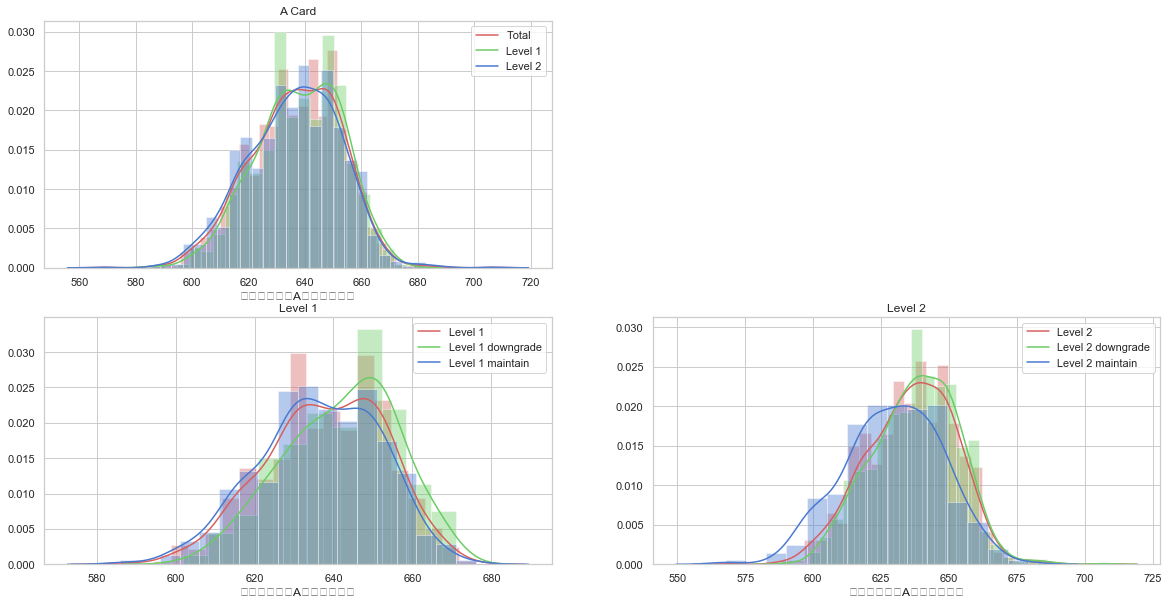

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']='SimHei'#设置中文显示

import seaborn as sns
sns.set(style="whitegrid",palette="muted", color_codes=True)

#为了在jupyter notebook里作图，需要用到这个命令
%matplotlib inline   

fig = plt.figure(facecolor='white',figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['初始A卡分'],kde_kws={"label":"Total"},color="r",ax=ax1)
sns.distplot(df[df['是否1档']== 1]['初始A卡分'],kde_kws={"label":"Level 1"},color="g",ax=ax1)
sns.distplot(df[df['是否2档']== 1]['初始A卡分'],kde_kws={"label":"Level 2"},color="b",ax=ax1)
ax1.set_title(label='A Card', loc='center')

ax2 = fig.add_subplot(2,2,3)
sns.distplot(df[df['是否1档']== 1]['初始A卡分'],kde_kws={"label":"Level 1"},color="r",ax=ax2)
sns.distplot(df[(df['是否1档']== 1)&(df['调升/调降'] == '调降')]['初始A卡分'],kde_kws={"label":"Level 1 downgrade"},color="g",ax=ax2)
sns.distplot(df[(df['是否1档']== 1)&(df['调升/调降'] == '不变')]['初始A卡分'],kde_kws={"label":"Level 1 maintain"},color="b",ax=ax2)
ax2.set_title(label='Level 1', loc='center')


ax3 = fig.add_subplot(2,2,4)
sns.distplot(df[df['是否2档']== 1]['初始A卡分'],kde_kws={"label":"Level 2"},color="r",ax=ax3)
sns.distplot(df[(df['是否2档']== 1)&(df['调升/调降'] == '调降')]['初始A卡分'],kde_kws={"label":"Level 2 downgrade"},color="g",ax=ax3)
sns.distplot(df[(df['是否2档']== 1)&(df['调升/调降'] == '不变')]['初始A卡分'],kde_kws={"label":"Level 2 maintain"},color="b",ax=ax3)
ax3.set_title(label='Level 2', loc='center')

Text(0.5,1,'Level 2 Credit')

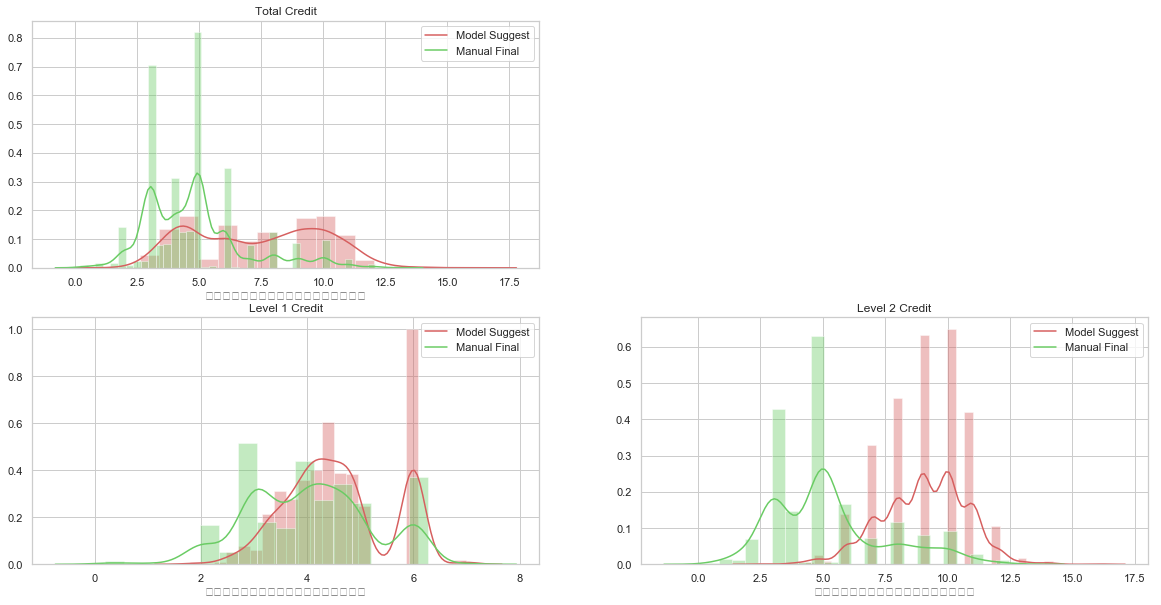

In [27]:
fig = plt.figure(facecolor='white',figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['模型给予额度'],kde_kws={"label":"Model Suggest"},color="r",ax=ax1)
sns.distplot(df['最后授信额度'],kde_kws={"label":"Manual Final"},color="g",ax=ax1)
ax1.set_title(label='Total Credit', loc='center')


ax2 = fig.add_subplot(2,2,3)
sns.distplot(df[df['是否1档']== 1]['模型给予额度'],kde_kws={"label":"Model Suggest"},color="r",ax=ax2)
sns.distplot(df[df['是否1档']== 1]['最后授信额度'],kde_kws={"label":"Manual Final"},color="g",ax=ax2)
ax2.set_title(label='Level 1 Credit', loc='center')

ax3 = fig.add_subplot(2,2,4)
sns.distplot(df[df['是否2档']== 1]['模型给予额度'],kde_kws={"label":"Model Suggest"},color="r",ax=ax3)
sns.distplot(df[df['是否2档']== 1]['最后授信额度'],kde_kws={"label":"Manual Final"},color="g",ax=ax3)
ax3.set_title(label='Level 2 Credit', loc='center')